In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.set_option('display.max_colwidth', None)

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


**POS_CASH_balance.csv**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.****

# A first sight to our dataset

In [2]:
#Columns description (145-152)
columns_description = pd.read_csv('../input/home-credit-default-risk/HomeCredit_columns_description.csv', encoding = 'ISO-8859-1')

In [3]:
columns_description[142:150]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previous credit,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,NaN


In [3]:
POS_CASH_balance = pd.read_csv("../input/home-credit-default-risk/POS_CASH_balance.csv") 

In [17]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [18]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [19]:
POS_CASH_balance.nunique()

SK_ID_PREV               936325
SK_ID_CURR               337252
MONTHS_BALANCE               96
CNT_INSTALMENT               73
CNT_INSTALMENT_FUTURE        79
NAME_CONTRACT_STATUS          9
SK_DPD                     3400
SK_DPD_DEF                 2307
dtype: int64

In [20]:
POS_CASH_balance.shape

(10001358, 8)

In [21]:
POS_CASH_balance.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [22]:
POS_CASH_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [24]:
#Calculate and visualize a percentage of missing values
missing_values_sr = POS_CASH_balance.isnull().sum()
missing_values_df = missing_values_sr.loc[missing_values_sr > 0].sort_values(ascending = False).reset_index()
missing_values_df.columns = ["Feature", "Number of missing values"]
missing_values_df["Percentage of missing values"] = (missing_values_df["Number of missing values"] / POS_CASH_balance.shape[0]) * 100
missing_values_df["Percentage of missing values"]

0    0.260835
1    0.260675
Name: Percentage of missing values, dtype: float64

Text(0.5, 1.0, 'Percentage of missing values in the pos cash balance data')

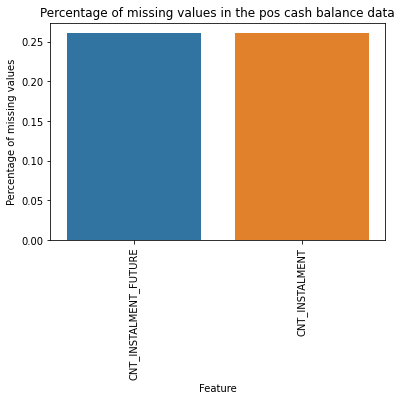

In [23]:
sns.barplot(x = missing_values_df["Feature"], y = missing_values_df["Percentage of missing values"])
plt.xticks(rotation = 90)
plt.title("Percentage of missing values in the pos cash balance data")

Here, only two features have a missing values. The amount of missing values is very small (0.25%) and identical for both features.

In [8]:
#Drop 2 features 'SK_ID_PREV','SK_ID_CURR' because I think it doesn't need to extract 
#information of 2 features when we do EDA
POS_CASH_balance.drop(['SK_ID_PREV','SK_ID_CURR'], axis = 1, inplace=True)
print('POS_CASH Shape:', POS_CASH_balance.shape)
POS_CASH_balance.head(5)

POS_CASH Shape: (10001358, 6)


,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,-31,48.0,45.0,Active,0,0
1,-33,36.0,35.0,Active,0,0
2,-32,12.0,9.0,Active,0,0
3,-35,48.0,42.0,Active,0,0
4,-35,36.0,35.0,Active,0,0


# PERFORMING EDA

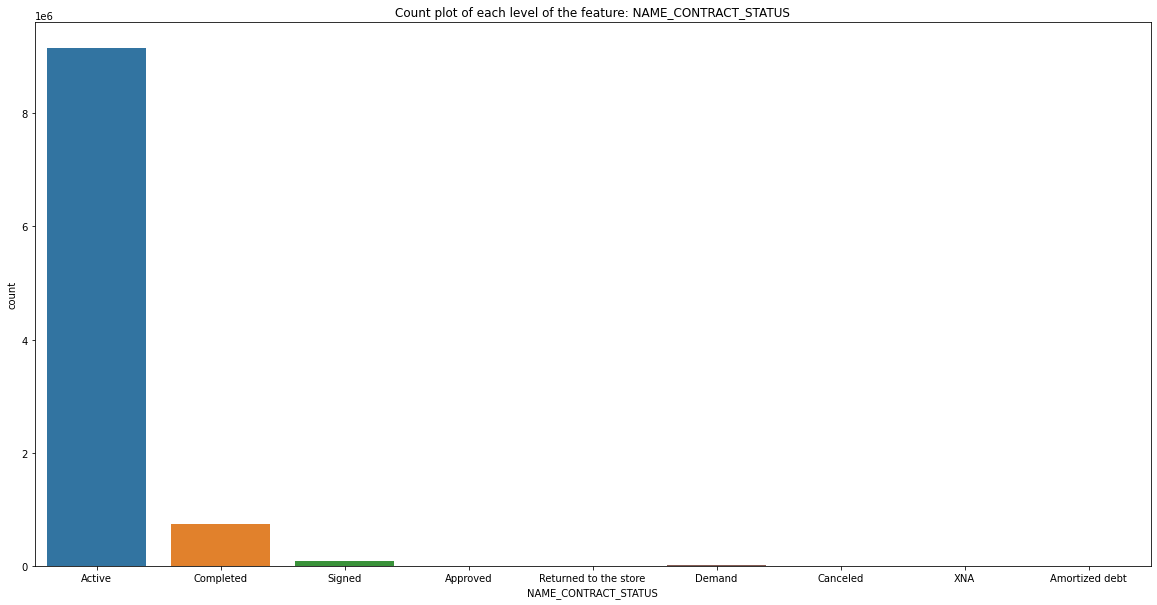

In [5]:
#Select all the columns that have 'object' type to  extract information from each features
categorical_features_lst = POS_CASH_balance.select_dtypes(["object"]).columns.tolist()

for feature in categorical_features_lst:
    fig, ax = plt.subplots(figsize = (20, 10)) 
    if POS_CASH_balance[feature].nunique() < 10:
        sns.countplot(data = POS_CASH_balance, x = feature)
    else: 
        sns.countplot(data = POS_CASH_balance, y = feature)
    ax.set_title("Count plot of each level of the feature: " + feature)

In this dataset, there is only one categorical feature that indicates the contract status on the previous application. We can see that most previous application are still active.

In [6]:
#Select columns which have 2 types "float64", "int64"
numerical_features_lst = list(set(POS_CASH_balance.columns.tolist()) - set(categorical_features_lst))

# generate the linkage matrix
numerical_features_df = POS_CASH_balance[numerical_features_lst]
numerical_features_df.fillna(-1, inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# Histogram of the numerical features

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


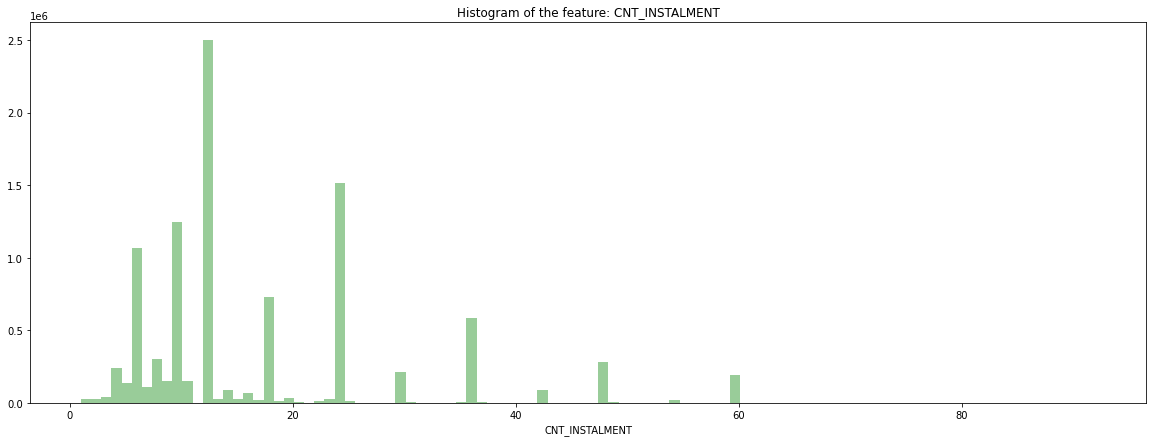

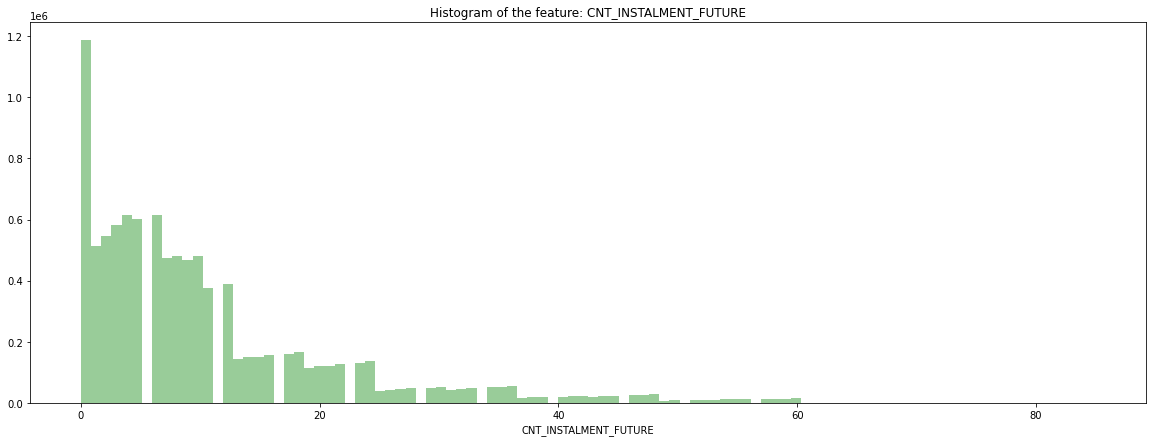

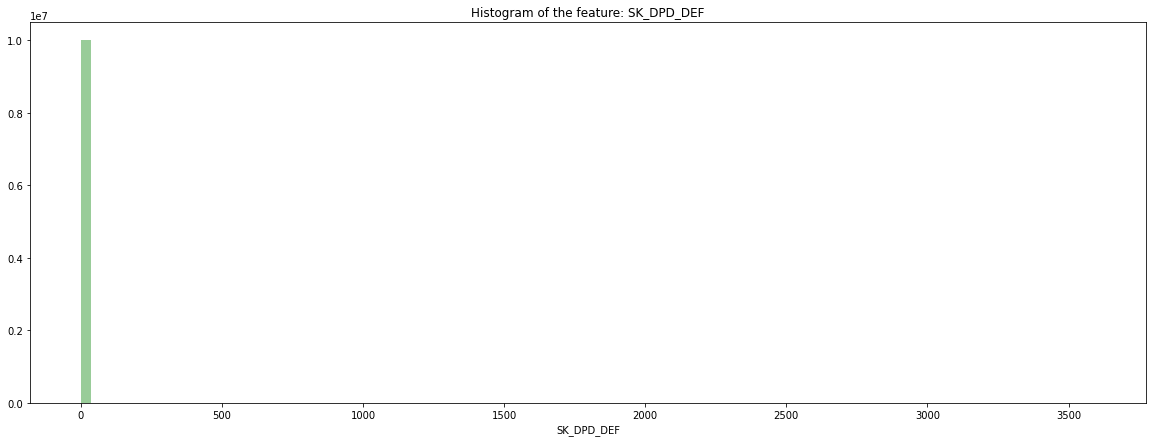

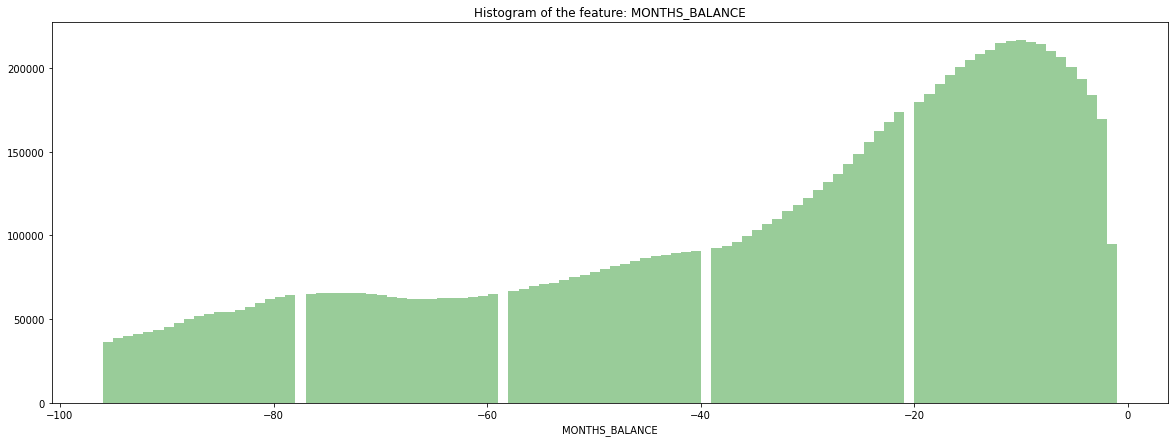

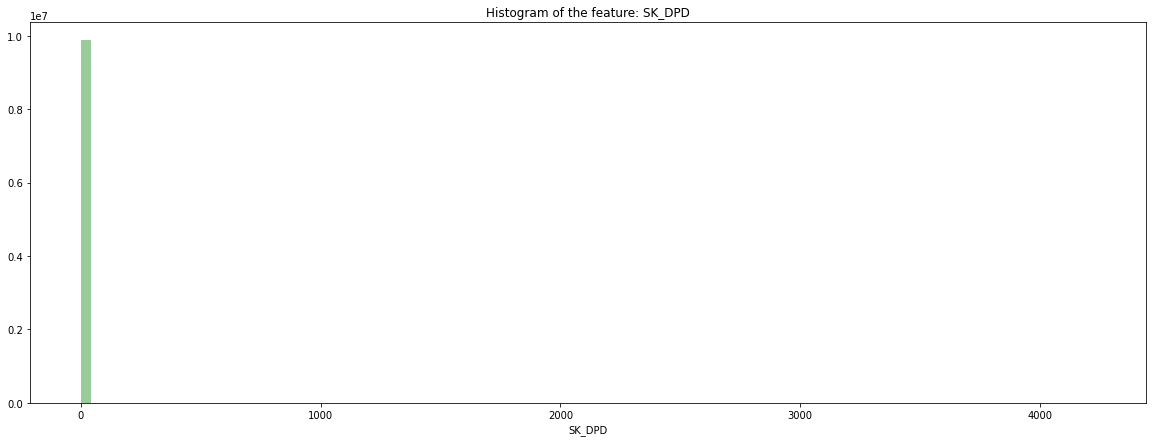

In [14]:
#Visualize all numerical features to see problems
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 1, sharex = False, sharey = False, figsize = (20, 7))
    
    # Plot feature distribution
    sns.distplot(POS_CASH_balance[feature].dropna(), kde = False, bins = 100, ax = ax, color = 'g')
    ax.set_title("Histogram of the feature: " + feature)

Here we can see lots of outliers in the features and high skewness. There are also missing bins in MONTHS_BALANCE.

We can see that SK_DPD_DEF vs SK_DPD have a lot of 0 value.

# Check outlier for numerical features

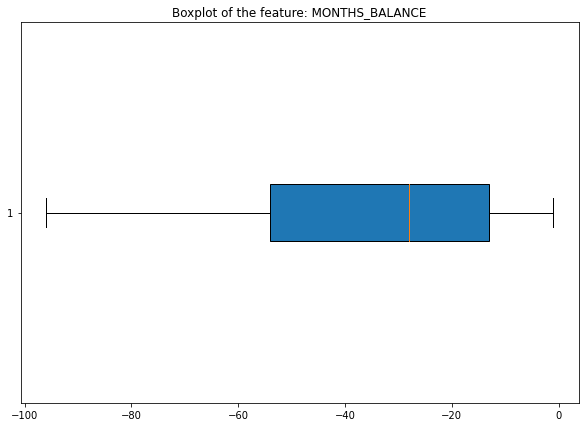

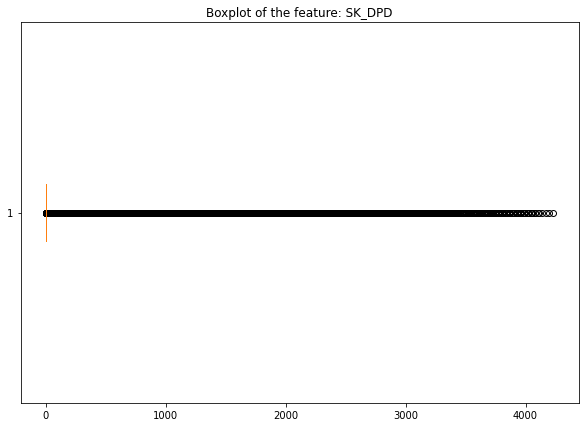

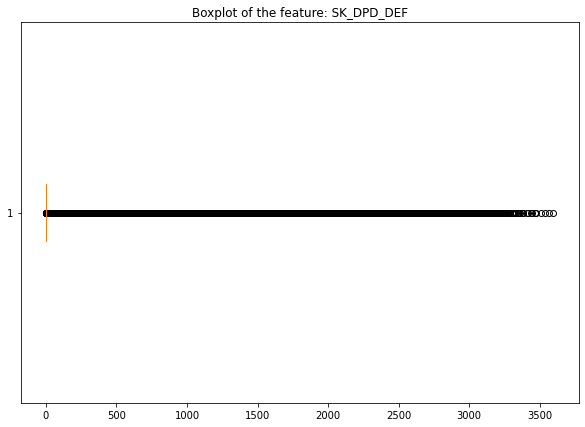

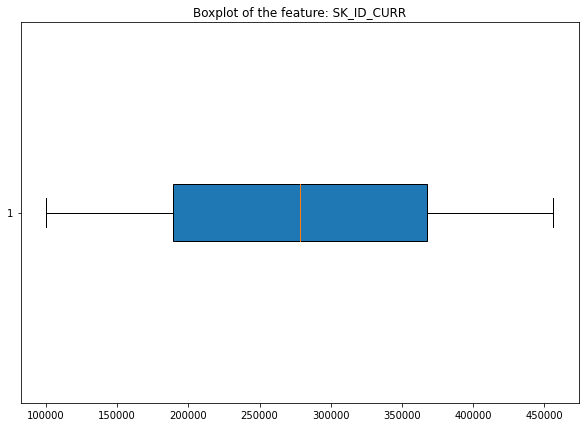

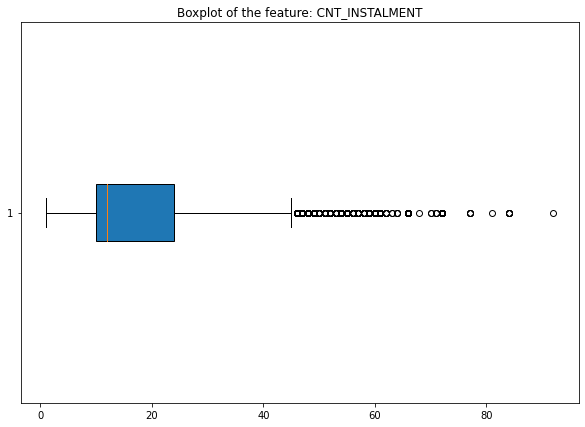

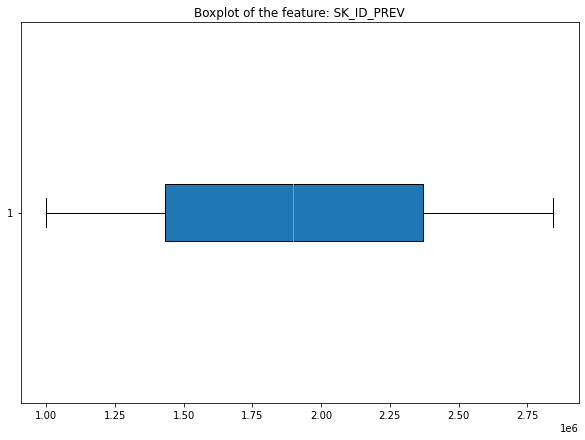

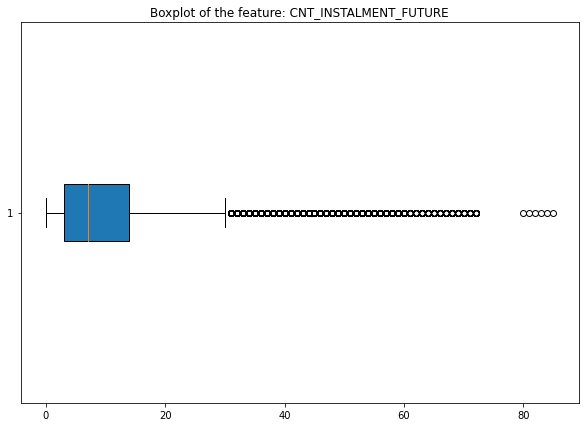

In [8]:
for feature in numerical_features_lst:
    fig, ax = plt.subplots(1, 1, figsize = (10, 7))
    plt.boxplot(POS_CASH_balance[feature].dropna(), patch_artist =True, vert = False)
    ax.set_title("Boxplot of the feature: " + feature)

We can see that SK_DPD, SK_DPD_DEF, CNT_INSTALMENT, CNT_INSTALMENT_FUTURE have outlier values

# Plot heatmap to show correlation between numerical features

Text(0.5, 1.0, 'Correlation plot between numerical features')

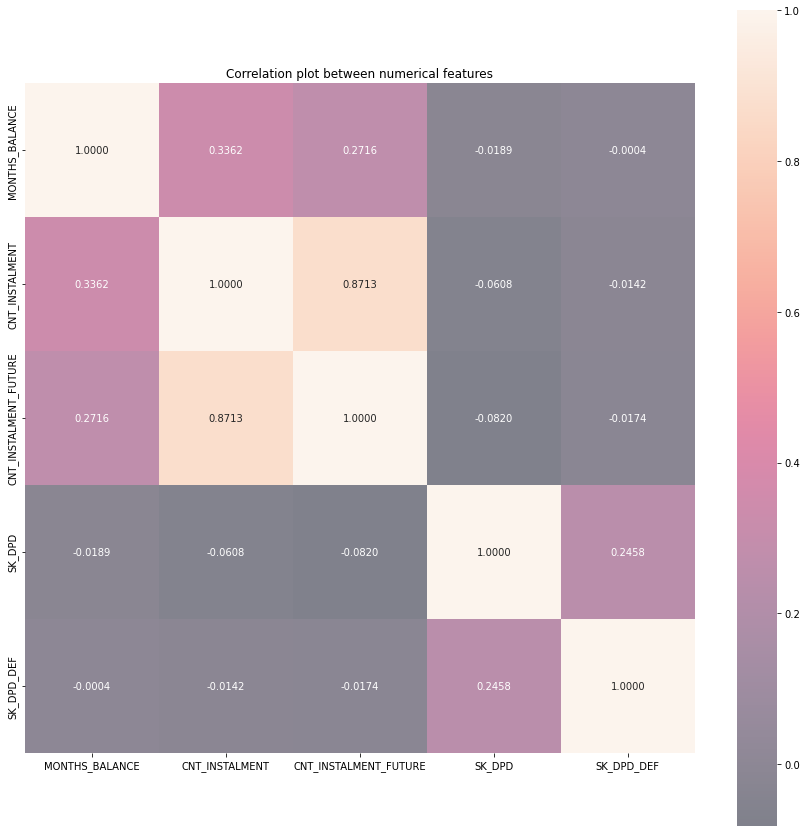

In [30]:
plt.figure(figsize = (15, 15))
sns.heatmap(POS_CASH_balance.corr(), annot = True, alpha = 0.5, fmt = ".4f", square = True)
plt.title("Correlation plot between numerical features")

Here, we can see that CNT_INSTALMENT and CNT_INTSALMENT_FUTURE are highly correlated but not enough to remove

# END EDA

# DATA CLEANING

In [10]:
null_percent = pd.DataFrame()
percent = POS_CASH_balance.isnull().sum()/POS_CASH_balance.shape[0]* 100
null_percent['Percentage of missing values'] = percent
null_percent

,Percentage of missing values
SK_ID_PREV,0.000000
SK_ID_CURR,0.000000
MONTHS_BALANCE,0.000000
CNT_INSTALMENT,0.260675
CNT_INSTALMENT_FUTURE,0.260835
NAME_CONTRACT_STATUS,0.000000
SK_DPD,0.000000
SK_DPD_DEF,0.000000


The percentage of missing values is too low, we don't need to delete any feature by this way

The correlation of each couple features is under |0.9|, we don't need to delete any feature by this way

In [24]:
#Show the percentage of zero values in two columns 'SK_DPD', 'SK_DPD_DEF'
percent_zero = pd.DataFrame()
percent1 = (POS_CASH_balance[POS_CASH_balance['SK_DPD'] == 0]['SK_DPD'].value_counts().sum()/POS_CASH_balance.shape[0])* 100
percent2 = (POS_CASH_balance[POS_CASH_balance['SK_DPD_DEF'] == 0]['SK_DPD_DEF'].value_counts().sum()/POS_CASH_balance.shape[0])* 100
percent_zero['Percentage of zero values'] = percent1, percent2
percent_zero.index = ['SK_DPD', 'SK_DPD_DEF']
percent_zero

,Percentage of zero values
SK_DPD,97.048131
SK_DPD_DEF,98.860465


SK_DPD_DEF vs SK_DPD have a lot of 0 value (nearly 100%), so we delete these features

In [25]:
POS_CASH_balance.drop(['SK_DPD_DEF','SK_DPD'], inplace=True, axis = 1)

In [26]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS
0,1803195,182943,-31,48.0,45.0,Active
1,1715348,367990,-33,36.0,35.0,Active
2,1784872,397406,-32,12.0,9.0,Active
3,1903291,269225,-35,48.0,42.0,Active
4,2341044,334279,-35,36.0,35.0,Active
